In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from keras_vggface.vggface import VGGFace
from sklearn.metrics import confusion_matrix, classification_report
from scipy.special import softmax
from keras_vggface.vggface import VGGFace

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

/home/ld/anaconda3/envs/dl/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.7.0-dev20210924). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


TensorFlow Version 2.7.0-dev20210924


In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 200

train_dir = '../dataset/data/classified'
val_dir = '../dataset/data/validation'
test_dir = '../dataset/data/test'

classes = {0 : "Baby",
           1 : "Not Baby"}

In [3]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_2 >= .4:
        image = tf.image.random_contrast(image, lower = .8, upper = 1.2)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [4]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          preprocessing_function = data_augment)

val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True)


val_test_datagen.apply_transform

train_ds = datagen.flow_from_directory(
        train_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        seed = 1,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

val_ds = val_test_datagen.flow_from_directory(
        val_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        shuffle = True,
        class_mode='binary')

test_ds = val_test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        color_mode = 'rgb',
        class_mode='binary')

# test_ds = tf.keras.utils.image_dataset_from_directory(
#         test_dir,
#         image_size=(IMAGE_SIZE, IMAGE_SIZE),
#         batch_size=BATCH_SIZE)

Found 97 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


2021-09-26 15:49:19.676823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 15:49:19.686343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 15:49:19.687069: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 15:49:19.688949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-26 15:49:19.689673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from S

(224, 224, 3)


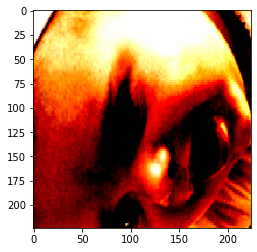

In [5]:
x = train_ds.next()
image = x[0][0]
print(image.shape)
plt.imshow(image)

In [6]:
cat_img = plt.imread('../dataset/data/classified/baby/1.jpeg')

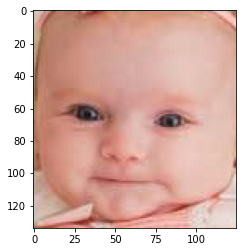

In [7]:
plt.imshow(cat_img)

In [8]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_gen.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [9]:
# vit_model = vit.vit_b32(
#         image_size = IMAGE_SIZE,
#         activation = 'softmax',
#         pretrained = True,
#         include_top = False,
#         pretrained_top = False,
#         classes = 2)

vgg_model = VGGFace(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), pooling='avg') 
vgg_model.trainable = False

In [10]:
# model = tf.keras.Sequential([
#         vggface,
#         tf.keras.layers.Flatten(),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(16, activation = "relu"),
#         tf.keras.layers.BatchNormalization(),
#         tf.keras.layers.Dense(1, 'sigmoid')
#     ],
#     name = 'vision_transformer')


x = tf.keras.layers.Flatten(name='flatten')(vgg_model.output)
x = tf.keras.layers.Dense(16, activation='relu',)(x)
out = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')(x)
custom_vgg_model = tf.keras.Model(vgg_model.input, out)

custom_vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0     

In [11]:
learning_rate = 1e-4

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)

custom_vgg_model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.binary_crossentropy, 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_ds.n // train_ds.batch_size
# STEP_SIZE_VALID = val_ds.n // val_ds.batch_size

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 10,
#                                                  verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 50,
                                                 mode = 'max',
#                                                  verbose = 1,
                                                 restore_best_weights = True)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model_vgg.hdf5',
                                                  monitor = 'val_accuracy', 
#                                                   verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [checkpointer, earlystopping, reduce_lr] #reduce_lr earlystopping



In [ ]:
custom_vgg_model.fit(x = train_ds,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = val_ds,
          epochs = EPOCHS,
          callbacks = callbacks)

custom_vgg_model.save('model_vgg.h5')

Epoch 1/200


2021-09-26 15:49:23.180821: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
2021-09-26 15:49:25.059346: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-09-26 15:49:25.059451: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.54GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


6/6 [==============================] - 11s 981ms/step - loss: 0.6902 - accuracy: 0.6173 - val_loss: 0.6984 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/200
6/6 [==============================] - 2s 416ms/step - loss: 0.6906 - accuracy: 0.5432 - val_loss: 0.6974 - val_accuracy: 0.5385 - lr: 1.0000e-04
Epoch 3/200
6/6 [==============================] - 2s 266ms/step - loss: 0.6927 - accuracy: 0.5417 - val_loss: 0.6963 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/200
6/6 [==============================] - 1s 271ms/step - loss: 0.6874 - accuracy: 0.6420 - val_loss: 0.6948 - val_accuracy: 0.5385 - lr: 1.0000e-04
Epoch 5/200
6/6 [==============================] - 2s 337ms/step - loss: 0.6850 - accuracy: 0.6914 - val_loss: 0.6933 - val_accuracy: 0.5769 - lr: 1.0000e-04
Epoch 6/200
6/6 [==============================] - 1s 234ms/step - loss: 0.6856 - accuracy: 0.6420 - val_loss: 0.6920 - val_accuracy: 0.5769 - lr: 1.0000e-04
Epoch 7/200
6/6 [==============================] - 1s 228ms/ste

In [ ]:
# test_model = tf.keras.models.load_model("./Models/best_model.h5")

In [ ]:
# test_model.evaluate(test_ds)

In [ ]:
custom_vgg_model.evaluate(test_ds)

In [ ]:
res = custom_vgg_model.predict(test_ds)

In [ ]:
res

In [ ]:
res[res >= 0.5] = 1

In [ ]:
res[res < 0.5] = 0

In [ ]:
res

In [ ]:
# test_ds